# **CLUSTERING**

# **Data preprocessing**




**Import the libraries**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
# Load the dataset
df = pd.read_csv("./Live.csv")  # Replace "your_dataset.csv" with the path to your dataset file



In [3]:
# Display the first few rows of the dataset to understand its structure
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

(                          status_id status_type status_published  \
 0  246675545449582_1649696485147474       video   4/22/2018 6:00   
 1  246675545449582_1649426988507757       photo  4/21/2018 22:45   
 2  246675545449582_1648730588577397       video   4/21/2018 6:17   
 3  246675545449582_1648576705259452       photo   4/21/2018 2:29   
 4  246675545449582_1645700502213739       photo   4/18/2018 3:22   
 
    num_reactions  num_comments  num_shares  num_likes  num_loves  num_wows  \
 0            529           512         262        432         92         3   
 1            150             0           0        150          0         0   
 2            227           236          57        204         21         1   
 3            111             0           0        111          0         0   
 4            213             0           0        204          9         0   
 
    num_hahas  num_sads  num_angrys  Column1  Column2  Column3  Column4  
 0          1         1           

In [4]:
# Remove completely null columns
df_cleaned = df.drop(columns=['Column1', 'Column2', 'Column3', 'Column4'])


In [5]:

# Check for columns with unique values for every instance
cols_to_drop = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == len(df_cleaned)]

# Drop identified columns
df_cleaned = df_cleaned.drop(columns=cols_to_drop)

In [6]:
# Convert 'status_published' to datetime, then to Unix timestamp
df_cleaned['status_published'] = pd.to_datetime(df_cleaned['status_published'])
df_cleaned['status_published'] = df_cleaned['status_published'].astype('int64') // 10**9

In [7]:

# Define columns for transformation
categorical_cols = ['status_type']
numerical_cols = [col for col in df_cleaned.columns if col not in categorical_cols + ['status_published']]
numerical_cols += ['status_published']  # Add 'status_published' as a numerical column after conversion

In [8]:
# Define the preprocessing for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(feature_range=(-1, 1)), numerical_cols),  # Scale to range -1 to 1
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [9]:
# Apply the transformations
df_preprocessed = preprocessor.fit_transform(df_cleaned)

# Get the feature names for one-hot encoded columns
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine original numerical column names and one-hot encoded column names
all_feature_names = numerical_cols + list(ohe_feature_names)

In [10]:
# Convert the preprocessed data back to a dataframe with all feature names
df_preprocessed_with_names = pd.DataFrame(df_preprocessed, columns=all_feature_names)


In [11]:
# Save the dataframe with correct column names to a new CSV file
corrected_file_path = './Live_preprocessed_corrected.csv'
df_preprocessed_with_names.to_csv(corrected_file_path, index=False)

# **K MEANS CLUSTERING**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
df_preprocessed = pd.read_csv("./Live_preprocessed_corrected.csv")


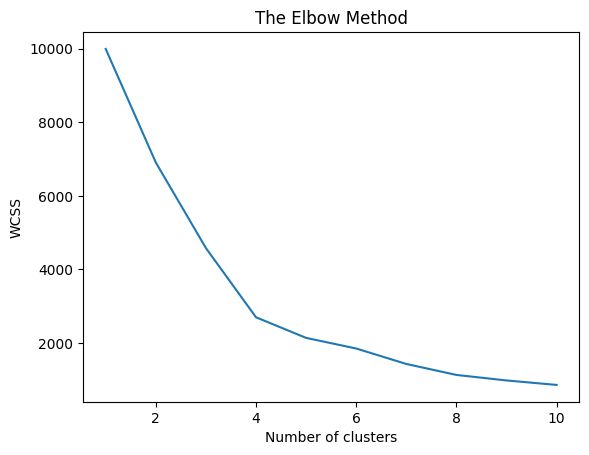

In [14]:
# Using all features for clustering
X = df_preprocessed.values

# Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)  # Explicitly setting n_init
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

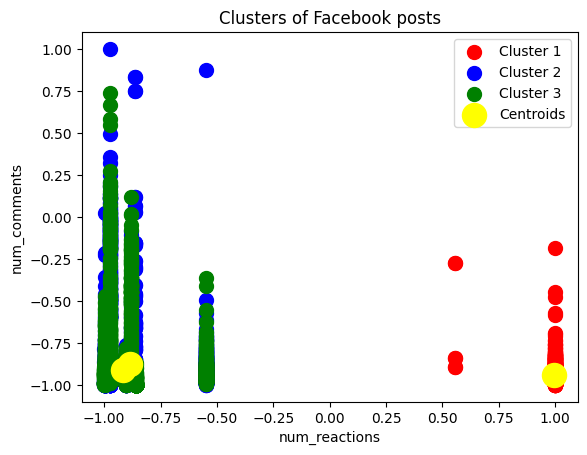

In [15]:
# Applying K-means with the optimal number of clusters
optimal_k = 3  # Assuming you choose the number of clusters based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42,n_init=10)
y_kmeans = kmeans.fit_predict(X)

# Visualizing the clusters (for 2D data)
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=100, c='green', label='Cluster 3')
# Add more colors for additional clusters if needed

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
plt.title('Clusters of Facebook posts')
plt.xlabel('num_reactions')
plt.ylabel('num_comments')
plt.legend()
plt.show()

In [17]:
# Group by cluster and calculate majority status_type for each cluster
cluster_majority_status = df_preprocessed.groupby('status_id').agg(lambda x: x.mode().iloc[0])

# Print the majority status_type for each cluster
print("Majority status_type for each cluster:")
print(cluster_majority_status[['status_type_link', 'status_type_photo', 'status_type_status', 'status_type_video']])



Majority status_type for each cluster:
           status_type_link  status_type_photo  status_type_status  \
status_id                                                            
-1.000000               0.0                0.0                 0.0   
-0.996717               0.0                1.0                 0.0   
-0.994337               0.0                1.0                 0.0   
-0.975054               0.0                1.0                 0.0   
-0.975054               0.0                1.0                 0.0   
-0.904192               0.0                1.0                 0.0   
-0.882804               0.0                0.0                 0.0   
-0.864766               0.0                1.0                 0.0   
-0.859233               0.0                0.0                 0.0   
-0.547765               0.0                1.0                 0.0   
 0.555108               0.0                1.0                 0.0   
 1.000000               0.0                1.0     


*   For Cluster 0, the majority status_type is 'photo'.
*   For Cluster 1, the majority status_type is 'photo'.
*   For Cluster 2, the majority status_type is 'video'.






# **Hierrarchial clustering**

In [18]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Load the preprocessed data
df_preprocessed = pd.read_csv("./Live_preprocessed_corrected.csv")

# Using all features for clustering
X = df_preprocessed.values

# Create a dendrogram to determine the optimal number of clusters
Z = linkage(X, method='ward')  # Using Ward's method for linkage

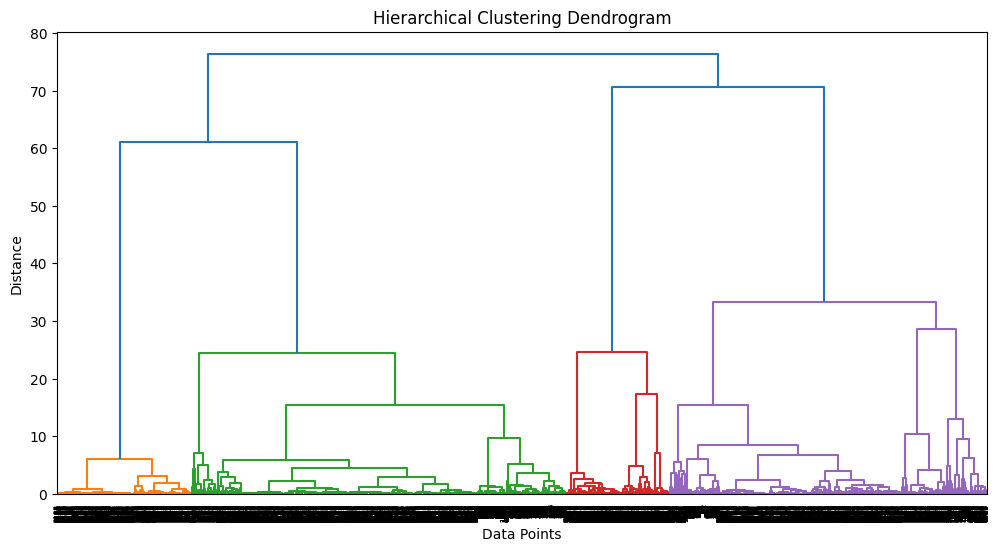

In [19]:
# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [20]:
optimal_clusters = 3

# Perform hierarchical clustering with the optimal number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters)
cluster_labels = agg_clustering.fit_predict(X)

In [21]:
 #Add cluster labels to the DataFrame
df_preprocessed['agg_cluster'] = cluster_labels

# Calculate the majority status_type for each cluster
agg_cluster_majority_status = df_preprocessed.groupby('agg_cluster').agg(lambda x: x.mode().iloc[0])


In [22]:
# Print the majority status_type for each cluster
print("Majority status_type for each hierarchical cluster:")
print(agg_cluster_majority_status[['status_type_link', 'status_type_photo', 'status_type_status', 'status_type_video']])

Majority status_type for each hierarchical cluster:
             status_type_link  status_type_photo  status_type_status  \
agg_cluster                                                            
0                         0.0                1.0                 0.0   
1                         0.0                0.0                 0.0   
2                         0.0                1.0                 0.0   

             status_type_video  
agg_cluster                     
0                          0.0  
1                          1.0  
2                          0.0  


Based on the majority status_type for each hierarchical cluster:


*   For Cluster 0, the majority status_type is 'photo'.
*   For Cluster 1, the majority status_type is 'video'.
*   For Cluster 2, the majority status_type is 'photo'.

This means that the majority of Facebook Live posts in Cluster 0 and Cluster 2 are of type 'photo', while the majority of posts in Cluster 1 are of type 'video'.